# CSII 2023 Exercise 02: State Feedback for Duckiebot Steering Modawg flavor

Reference: 
- [Python Control Systems Library](https://python-control.readthedocs.io/en/0.9.3.post2/steering.html)
- Karl J. Astrom and Richard M. Murray 23 Jul 2019

## State Feedback for Duckiebot Steering
The dynamics of the Duckiebot are given by a simple unicycle model, which is similar to the Duckiebot model presented in the first lecture. We take the state of the system as $(x, y, \theta)$ where $(x, y)$ is the position of the reference point of the Duckiebot in the plane and $\theta$ is the angle of the Duckiebot with respect to the x-axis. The input of the Duckiebot is given by $(v, \omega)$ where $v$ is the forward velocity and $\omega$ is the angular speed. The difference from the lecture formulation is that we use absolute coordinates in global frame $(x, y, \theta)$ for our states and not relative states to our reference line as shown in the figure $(d,\theta)$. 

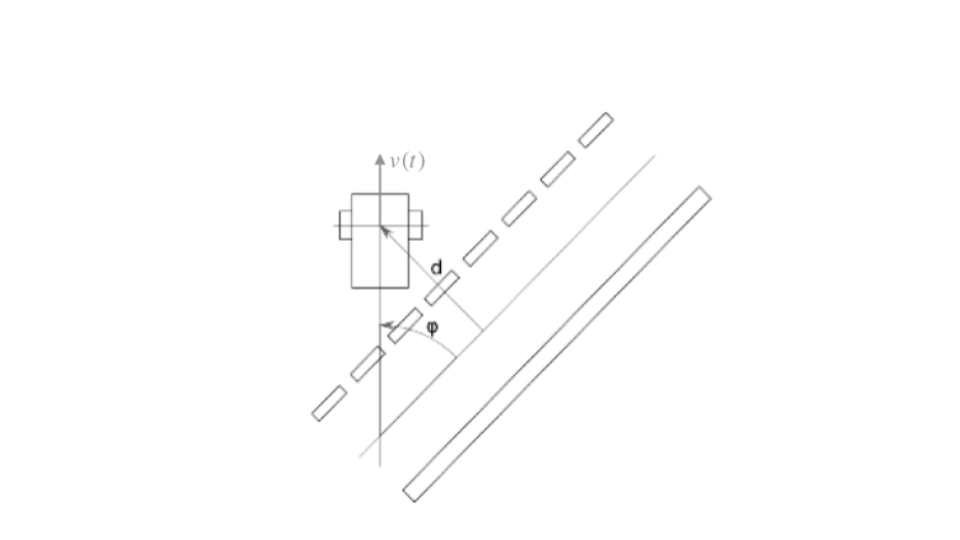

-------
## Installation 
We use the [Python library](https://python-control.readthedocs.io/en/0.9.3.post2/) `control`, which can be installed using `pip`. If you have no experience with Python, try to do some tutorials (e.g. check [this](https://docs.python.org/3/tutorial/) one). The same goes for installing Python packages using `pip`, see this [tutorial](https://packaging.python.org/en/latest/tutorials/installing-packages/). There are plenty of other Python tutorials for beginners if you do a Google/YouTube search. 





In [1]:
# Install the required python library with pip 
%pip install control

Note: you may need to restart the kernel to use updated packages.


------
## Python Packages
We use the following Python libraries which need to be imported. If you have no experience with the [NumPy](https://numpy.org/) library, read the documentation and do some tutorials. It is very important for matrix operations in Python.



In [17]:
# Import the required python libraries
from typing import Optional, List
import numpy as np
import matplotlib.pyplot as plt
import control as ct

## Dynamics

The nonlinear dynamics and the output of the Duckiebot are defined in the next cell.
v is the velocity of the duckybot. This variable is stored in u[0].
The angular velocity omega is stored in u[1].
The array x contains the x-position of the duckybot at x[0],
the y-position at x[1], and the angle with respect to the x-axis θ at x[2].
Theses three values are the states of the system.

As you can see in the update function, the system is nonlinear in θ and thus needs to be linearized in later.

In [3]:
def unicycle_update(t: float, x: np.array, u: np.array, params: dict):
    # Return the derivative of the state
    max_omega = params.get('max_omega', 0.05)
    omega = np.clip(u[1], -max_omega, max_omega)
    return np.array([
        u[0] * np.cos(x[2]),    # xdot = v cos(theta)
        u[0] * np.sin(x[2]),    # ydot = v sin(theta)
        omega     # thdot = omega
    ])

def unicycle_output(t: float, x: np.array, u: np.array, params: dict):
    return x[0:2]

## Plotting
The next cell implements some plotting functions using the [Matplotlib](https://matplotlib.org/) library. If you are interested, take a look.

In [61]:
#@title
def plot_track(x_coord_ref: np.array, y_coord_ref: np.array, 
               theta_ref: np.array, t: np.array, 
               w_curvy: np.array, 
               y_ctr: Optional[np.array] = None,
               w_ctr: Optional[np.array] = None) -> None:
    # Configure matplotlib plots to be a bit bigger and optimize layout
    plt.figure(figsize=[9, 4.5])
    # Plot the resulting trajectory (and some road boundaries)
    plt.subplot(1, 4, 2)
    plt.plot(y_coord_ref, x_coord_ref)
    plt.legend(['Reference'])
    if y_ctr is not None:
        plt.plot(y_ctr, x_coord_ref, 'r', linewidth=1)
        plt.legend(['Reference', 'controller'])
    else:
        plt.legend(['Reference'])
    plt.plot(y_coord_ref - 0.9/np.cos(theta_ref), x_coord_ref, 'k-', linewidth=1)
    plt.plot(y_coord_ref - 0.3/np.cos(theta_ref), x_coord_ref, 'k--', linewidth=1)
    plt.plot(y_coord_ref + 0.3/np.cos(theta_ref), x_coord_ref, 'k-', linewidth=1)
    
    
    
    plt.xlabel('y [m]')
    plt.ylabel('x [m]');
    plt.axis('Equal')

    # Plot the lateral position
    plt.subplot(2, 2, 2)
    plt.plot(t, y_coord_ref)
    if y_ctr is not None:
        plt.plot(t_curvy, y_ctr, 'r')
        plt.legend(['Reference', 'controller'])
    else:
        plt.legend(['Reference'])
    plt.ylabel('Lateral position $y$ [m]')

    # Plot the control input
    plt.subplot(2, 2, 4)
    plt.plot(t, w_curvy)
    if w_ctr is not None:
        plt.plot(t_curvy, w_ctr, 'r')
        plt.legend(['Reference', 'Controller'])
    else:
        plt.legend(['Reference'])
    plt.ylabel('$\\omega$ [rad/s]')
    plt.xlabel('Time t [sec]')
    plt.tight_layout()


def plot_track_multiple_controller(x_coord_ref: np.array, y_coord_ref: np.array, 
               theta_ref: np.array, t: np.array, 
               w_curvy: np.array, 
               y_ctr: List[np.array],
               w_ctr: Optional[np.array]) -> None:
    # Configure matplotlib plots to be a bit bigger and optimize layout
    number_ctr = len(y_ctr)
    plt.figure(figsize=[14, 6])
    # Plot the resulting trajectory (and some road boundaries)

    plt.subplot(1, 4, 2)
    plt.plot(y_coord_ref, x_coord_ref)
    plt.legend(['Reference'])
    legend_list = ['Reference']
    for i in range(number_ctr):
        plt.plot(y_ctr[i], x_coord_ref, linewidth=1)
        legend_list.append(f'Controller {i+1}')
    
    plt.legend(legend_list, loc='upper left')
    plt.plot(y_coord_ref - 0.9/np.cos(theta_ref), x_coord_ref, 'k-', linewidth=1)
    plt.plot(y_coord_ref - 0.3/np.cos(theta_ref), x_coord_ref, 'k--', linewidth=1)
    plt.plot(y_coord_ref + 0.3/np.cos(theta_ref), x_coord_ref, 'k-', linewidth=1)
    
    
    
    plt.xlabel('y [m]')
    plt.ylabel('x [m]');
    plt.axis('Equal')

    # Plot the lateral position
    plt.subplot(2, 2, 2)
    plt.plot(t, y_coord_ref)
    legend_list = ['Reference']
    for i in range(number_ctr):
        plt.plot(t, y_ctr[i], linewidth=1)
        legend_list.append(f'Controller {i+1}')
    plt.legend(legend_list)
    plt.ylabel('Lateral position $y$ [m]')

    # Plot the control input
    plt.subplot(2, 2, 4)
    plt.plot(t, w_curvy)
    for i in range(number_ctr):
        plt.plot(t, w_ctr[i], linewidth=1)
        legend_list.append(f'Controller {i+1}')
    plt.legend(legend_list)
    plt.ylabel('$\\omega$ [rad/s]')
    plt.xlabel('Time t [sec]')
    plt.tight_layout()

# Utility function to plot the step response
def plot_step_response(t: np.array, y: np.array, u: np.array):
    axes_out = plt.subplot(2, 1, 1)
    plt.sca(axes_out)
    plt.plot(t, y)
    plt.ylabel('Lateral position $y$ in [m]')
    plt.plot([0, 20], [0.95, 0.95], 'k--')
    plt.plot([0, 20], [1.05, 1.05], 'k--')
    
    axes_input = plt.subplot(2, 1, 2)
    plt.sca(axes_input)
    plt.xlabel('Time t [sec]')
    plt.ylabel('$\omega$ [rad/s]')
    plt.plot(t, u[0])

def plot_sim_results(y_ref: np.array, y: np.array, 
                     theta_ref: np.array, theta: np.array,
                     t: np.array, w_ref: np.array,
                     w: np.array) -> None:
    # Configure matplotlib plots to be a bit bigger and optimize layout
    plt.figure(figsize=[15, 4.5])

    # Plot the actual and estimated states
    ax = plt.subplot(1, 2, 1)
    plt.plot(t, y)
    plt.plot(t, y_ref, 'k-.')
    ax.set(xlim=[0, 30])
    plt.legend(['state feedback', 'y', 'reference'])
    plt.xlabel('Time t [sec]')
    plt.ylabel('Lateral position $y$ [m]')

    ax = plt.subplot(2, 2, 2)
    plt.plot(t, theta)
    # plt.plot(t, x[3])
    plt.plot(t, theta_ref, 'k-.')
    ax.set(xlim=[0, 15])
    plt.ylabel('Angle $\\theta$ [rad]')

    ax = plt.subplot(2, 2, 4)
    plt.plot(t, w)
    # plt.plot(t, u_ofb[0])
    plt.plot(t, w_ref, 'k-.')
    ax.set(xlim=[0, 15])
    plt.xlabel('Time t [sec]')
    plt.ylabel('$\\omega$ [rad/s]')

<>:113: SyntaxWarning: invalid escape sequence '\o'
<>:113: SyntaxWarning: invalid escape sequence '\o'
C:\Users\mhepp\AppData\Local\Temp\ipykernel_19476\3784582131.py:113: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('$\omega$ [rad/s]')


## Parameters and Reference Track

We set a default Duckiebot velocity and generate the nonlinear system using the `control` library. 

In [5]:
# Default Duckiebot velocity in m/s
duckie_params={'velocity': 0.1, 'max_omega': 0.05}
# Define the Duckiebot's steering dynamics as an input/output system
duckiebot = ct.NonlinearIOSystem(
    unicycle_update, unicycle_output, states=3, name='duckiebot',
    inputs=('v', 'w'), outputs=('x', 'y'), params=duckie_params)

v0 = duckie_params['velocity']


<span style="color:red">REWORK THIS so that students better understand whats happening</span>

We define a reference track that we want to follow. If you want to test an easy track, set `curve_difficulty_levels[0]`. For a hard track set `curve_difficulty_levels[1]`. The reference line is generated by simulating some given control inputs for a certain time. We keep the velocity input `v_curvy` constant and calculate a forced angular velocity `w_curvy`. d

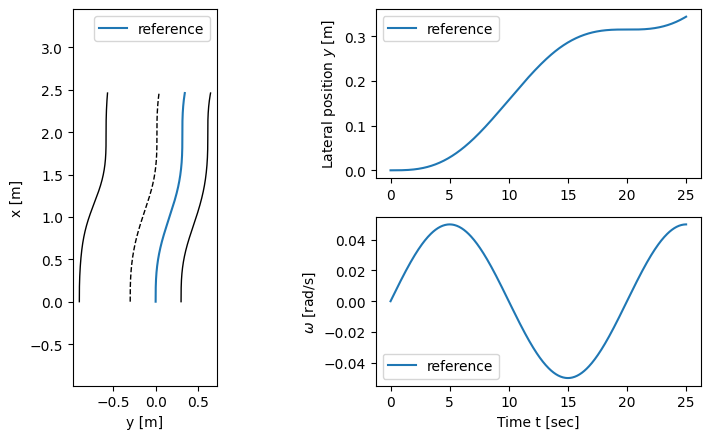

In [6]:
# Control inputs
curve_difficulty_levels = ['easy', 'hard']
curve_difficulty = curve_difficulty_levels[0]
T_curvy = np.linspace(0, 25, 500)
v_curvy = v0*np.ones(T_curvy.shape)
if curve_difficulty=='easy':
    w_curvy = 0.05*np.sin(T_curvy*np.pi/10)
elif curve_difficulty=='hard':
    w_curvy = 0.025*np.sin(T_curvy)*np.cos(4*T_curvy) + 0.025*np.sin(T_curvy*np.pi/10)
u_curvy = [v_curvy, w_curvy]
X0_curvy = [0, 0, 0]

# Simulate the system + estimator
t_curvy, y_curvy, x_curvy = ct.input_output_response(
    duckiebot, T_curvy, u_curvy, X0_curvy, params=duckie_params, return_x=True)

plot_track(y_curvy[0], y_curvy[1], x_curvy[2], t_curvy, w_curvy)

## Linearization, Normalization and State Space Represenation

In the next cell we show you how you to linearize and normalize the system using the `control` library. As shown in the class, we use $u_1=v_0$ as a constant for simplicity.


In [7]:
# Define the lateral dynamics as a subset of the full Duckiebot steering dynamics
lateral = ct.NonlinearIOSystem(
    lambda t, x, u, params: unicycle_update(
        t, [0., x[0], x[1]], [params.get('velocity', 1), u[0]], params)[1:],
    lambda t, x, u, params: unicycle_output(
        t, [0., x[0], x[1]], [params.get('velocity', 1), u[0]], params)[1:],
    states=2, name='lateral', inputs=('w'), outputs=('y')
)

# Compute the linearization at velocity v0 = 0.1 m/sec
lateral_linearized = ct.linearize(lateral, [0, 0], [0], params=duckie_params)

print("Linearized system dynamics:\n")
print(lateral_linearized)

# Save the system matrices for later use
A = lateral_linearized.A
B = lateral_linearized.B
C = lateral_linearized.C
D = lateral_linearized.D

Linearized system dynamics:

<LinearIOSystem>: sys[2]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (2): ['x[0]', 'x[1]']

A = [[0.  0.1]
     [0.  0. ]]

B = [[0.]
     [1.]]

C = [[1. 0.]]

D = [[0.]]



## State Feedback Control




Having reduced our model to just the lateral dynamics of the Duckiebot, we want to introduce a state feedback controller that can track a lateral position reference. By neglecting the longitudinal dynamics(assuming constant velocity) and linearizing about the operating point, we have obtained a SISO LTI system, where the state is given by $x = \begin{bmatrix} y & \theta \end{bmatrix}^\mathsf{T}$, the input is $u = \omega$, and the output is $y = y$, the lateral distance from the origin. 

Consider the state feedback controller $u = -Kx + k_r r$, where $K \in \mathbb{R}^{2 \times 1}$ is the state feedback gain matrix and $k_r$ is the feedforward gain. For zero steady state error, we choose $k_r = -\frac{1}{C(A-BK)^{-1}B}$. The dynamics of the closed loop system are then given by $$\dot{x} = (A - BK)x + k_r r = A_{cl}x + Bk_r r,$$ where $A_{cl} = A - BK $ is also called the closed loop state transition matrix. We can see that the stability of our system must now depend only on the eigenvalues of $A_{cl}$.





Introduce basic state feedback controller with guessed gains, maybe provide some gains that render the system unstable.

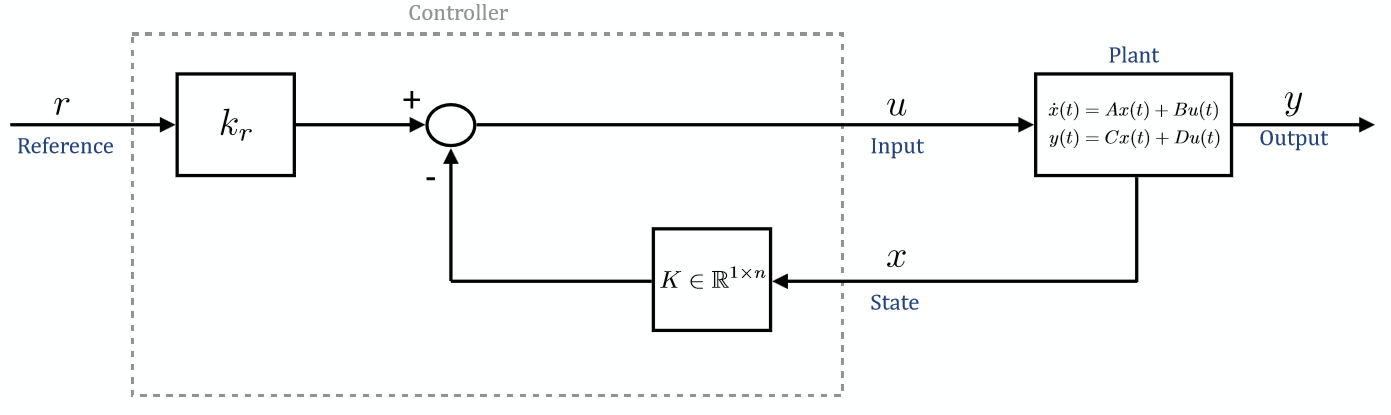


### Step Response with various K

First, we will try out some given values for K and look at the system response to a unit step reference. For this purpose, we define a new system with the closed loop dynamics stated in the cell above. We then simulate a step input and plot the output $d$, the reference $d_{ref}$ as well as the input $\omega$. 

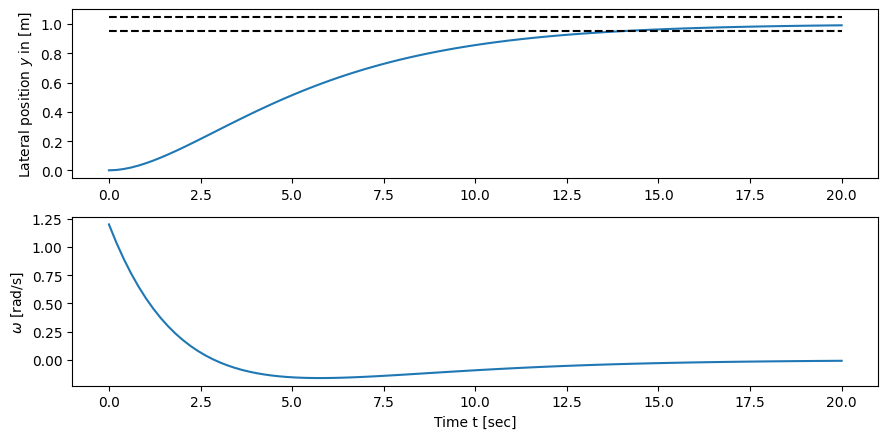

In [8]:
K1 = np.array([[1.2, 0.7]])
A_cl1 = A - B @ K1
assert np.linalg.det(A_cl1) != 0, "A - BK is not invertible"
k_r1 = -1/(C @ np.linalg.inv(A_cl1) @ B)
B_cl1 = B * k_r1
syscl1 = ct.ss(A_cl1, B_cl1, C, D)
# Compute the step response
t, y, x = ct.step_response(syscl1, np.linspace(0, 20, 100), return_x=True)
# Compute the input used to generate the control response (check lecture slides)
u = -K1 @ x + k_r1 * 1
# Configure matplotlib plots to be a bit bigger and optimize layout
plt.figure(figsize=[9, 4.5])
# Plot the results
plot_step_response(t, y, u)
plt.tight_layout()



Next, let's try out a gain matrix of $K = \begin{bmatrix} 32.5 & 0.2\end{bmatrix}$

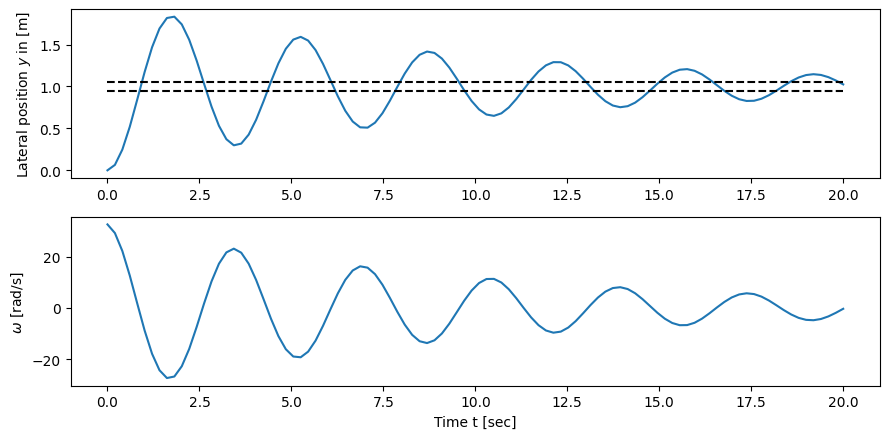

In [9]:
K2 = np.array([[32.5, 0.2]])
A_cl2 = A - B @ K2
assert np.linalg.det(A_cl2) != 0, "A - BK is not invertible"
k_r2 = -1/(C @ np.linalg.inv(A_cl2) @ B)
B_cl2 = B * k_r2
syscl2 = ct.ss(A_cl2, B_cl2, C, D)
# Compute the step response
t, y, x = ct.step_response(syscl2, np.linspace(0, 20, 100), return_x=True)
# Compute the input used to generate the control response (check lecture slides)
u = -K2 @ x + k_r2 * 1
# Configure matplotlib plots to be a bit bigger and optimize layout
plt.figure(figsize=[9, 4.5])
# Plot the results
plot_step_response(t, y, u)
plt.tight_layout()


Last, let's look at the step response given the gain matrix $K = \begin{bmatrix} 32.5 & -0.2\end{bmatrix}$

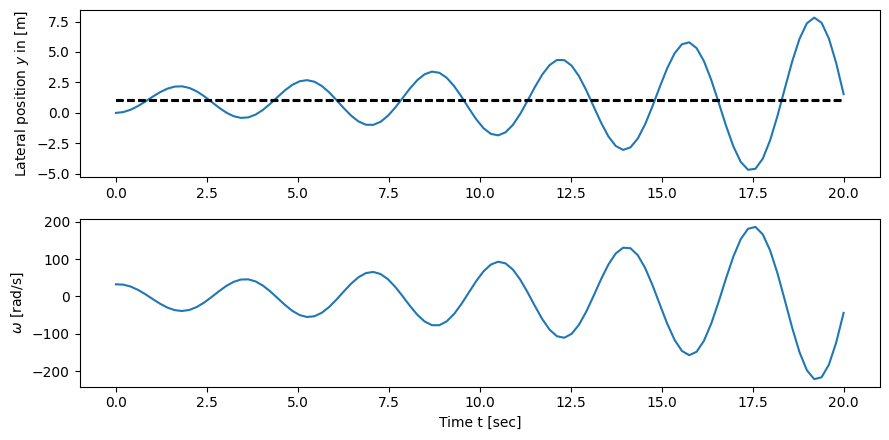

In [10]:
K3 = np.array([[32.5, -0.2]])
A_cl3 = A - B @ K3
assert np.linalg.det(A_cl3) != 0, "A - BK is not invertible"
k_r3 = -1/(C @ np.linalg.inv(A_cl3) @ B)
B_cl3 = B * k_r3
syscl3 = ct.ss(A_cl3, B_cl3, C, D)
# Compute the step response
t, y, x = ct.step_response(syscl3, np.linspace(0, 20, 100), return_x=True)
# Compute the input used to generate the control response (check lecture slides)
u = -K3 @ x + k_r3 * 1
# Configure matplotlib plots to be a bit bigger and optimize layout
plt.figure(figsize=[9, 4.5])
# Plot the results
plot_step_response(t, y, u)
plt.tight_layout()


### Exercise 1: Calculate Poles
Your first task is to calculate the poles of the closed loop system. Do they match your expectation after looking at the step responses? You may use the imported libraries numpy and control. 

In [263]:
# Calculate the poles of the closed-loop system for feedback gains K1, K2, and K3

### Exercise 1: Solution
The poles of the closed loop system are the eigenvalues of the closed loop dynamics matrix $A_{cl} = A - BK$. These are easily obtained using the library function np.linalg.eigvals.
The obtained values should align with our intuition from control systems I. If we have real poles with negative real part, the output converges to the reference without any overshoot. If the poles have negative real part, but nonzero imaginary part, the output still converges to the reference, but oscillates. If the poles have positive real part, the output diverges.

In [11]:
print("The poles of the closed-loop system for K1 are:", np.linalg.eigvals(A_cl1))
print("The poles of the closed-loop system for K2 are:", np.linalg.eigvals(A_cl2))
print("The poles of the closed-loop system for K3 are:", np.linalg.eigvals(A_cl3))


The poles of the closed-loop system for K1 are: [-0.3 -0.4]
The poles of the closed-loop system for K2 are: [-0.1+1.8j -0.1-1.8j]
The poles of the closed-loop system for K3 are: [0.1+1.8j 0.1-1.8j]


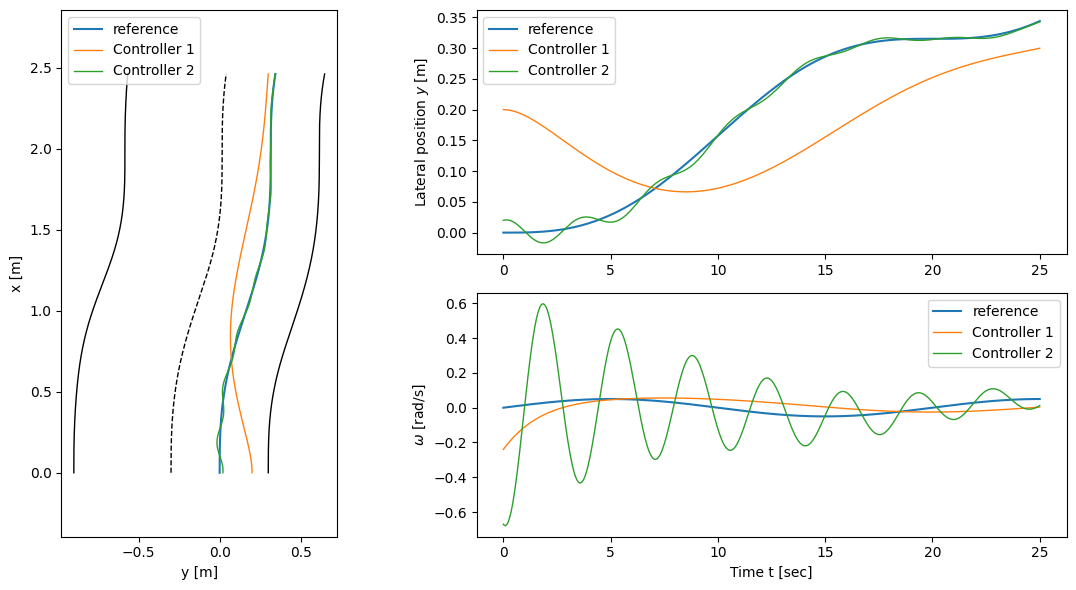

In [13]:
x_ref = x_curvy[0]
y_ref = x_curvy[1]
theta_ref = x_curvy[2]
omega_ref = w_curvy
t = T_curvy
x_0 = np.array([0.2, 0])
x_03 = np.array([0.02, 0.1])
t, y1, x1 = ct.forced_response(syscl1, T_curvy, y_ref, X0 = x_0, return_x=True)
omega1 = - K1 @ x1 + k_r1 * y_ref
t, y2, x2 = ct.forced_response(syscl2, T_curvy, y_ref, X0 = x_03, return_x=True)
omega2 = - K2 @ x2 + k_r2 * y_ref
t, y3, x3 = ct.forced_response(syscl3, T_curvy, y_ref, X0 = x_03, return_x=True)
omega3 = - K3 @ x3 + k_r3 * y_ref
y = np.array([y1, y2])
omega = np.array([omega1[0], omega2[0]])

plot_track_multiple_controller(x_ref, y_ref, theta_ref, t, omega_ref, y, omega)

# State Feedback Gain Matrix and the Ackermann Formula
To find appropriate values for the state feedback gain matrix K, we can make use of the Ackermann formula:
  
$$\mathbf{K} = [0\;...\;0\;1]\mathcal{R}^{-1}p_{cl}^{*}(A) = \gamma p_{cl}^{*}(A)$$
  
Where $\mathcal{R}$ is the Reachability Matrix of the system and $\gamma$ is the last row of the inverse of $\mathcal{R}$. The first step is the calculate the Reachability Matrix with the formula you have seen in class:
  
$$\mathcal{R} = [\;B\;AB\;...\;A^{n-1}B]$$

### Exercise X.1
calculate the $\mathcal{R}$ matrix using a for-loop. You can either do it for two dimensions or try and implement the code for the general case.

In [20]:
n = A.shape[0]  # number of states
m = B.shape[1]  # number of inputs

R = np.zeros((n, n*m))  # initialize R with zeros

# TODO Fill R using the reachability matrix formula
R[:, :m] = B
for i in range(1, n):
    R[:, i*m:(i+1)*m] = np.dot(A, R[:, (i-1)*m:i*m])

print(R)


[[0.  0.1]
 [1.  0. ]]


### Exercise X.2
Try and think of good values for the poles $s_1$ and $s_2$ and extract the coefficients of the resulting characteristic polynomial. For example, if we choose the poles at $s_1 = -1$ and $s_2 = -2$ the characteristic polynomial reads $p_{cl}^{*}(s) = s^2+3s + 2$ from which we see $a_0^{*} = 3, \;a_1^{*} = 2$  

Using your chosen values, implement the Ackermann formula to calculate the state feedback gain matrix K.

In [50]:
# Choose the values for the poles TODO
p_1 = -1
p_2 = -2
poles = np.array([p_1, p_2])

# Calculate the closed loop characteristic polynomial coefficients a_0 and a_1
coeffs = np.poly(poles)
a_0, a_1 = coeffs[1:]

# Evaluate the Ackermann formula TODO
select = np.zeros(n)
select[n-1] = 1 
p_cl = A @ A + a_0 * A + a_1 * np.eye(n)
K = np.array([select @ np.linalg.inv(R) @ p_cl])

print(K)

# Compute the state-space matrices of the closed loop system, which takes r as an input
A_cl = A - B @ K 
k_r = -1/(C @ np.linalg.inv(A_cl) @ B)
B_cl = B * k_r


[[20.  3.]]


The following code section visualizes tracking of a step reference using the just calculated state feedback gain matrix K. A pole-zero plot is also shown. 
After implementing state feedback, our system now reads:
$$ \dot{x}(t) = (A-BK)x(t) + Bk_r r(t)  $$

[-1. -2.]


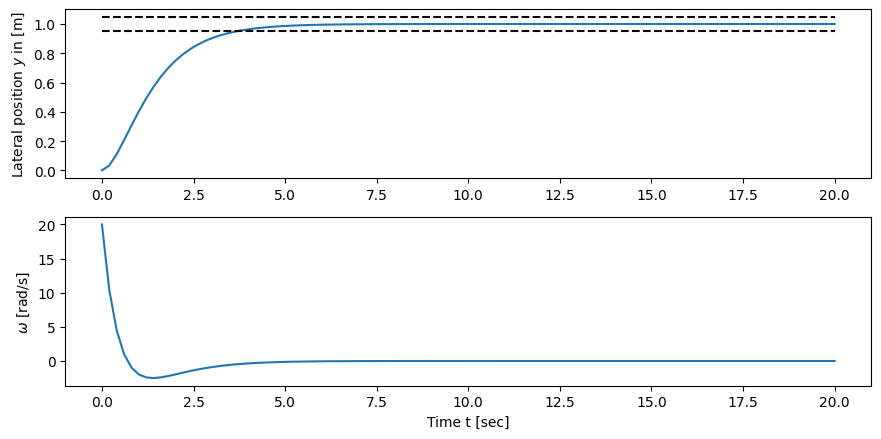

(array([-1.+0.j, -2.+0.j]), array([], dtype=complex128))

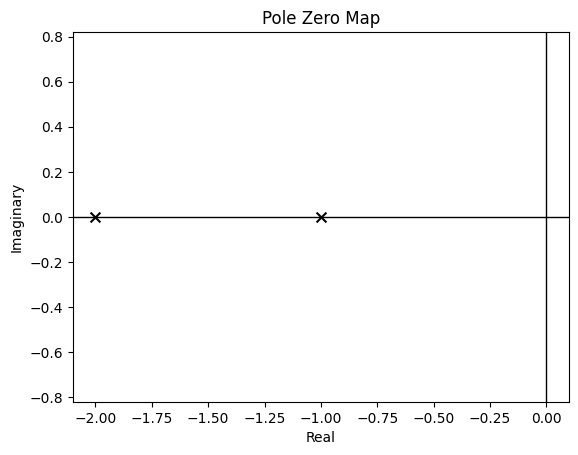

In [51]:
# Implement state feedback

syscl = ct.ss(A_cl, B_cl, C, D)
print(np.linalg.eigvals(A_cl))

# Compute the step response
t, y, x= ct.step_response(syscl, T=np.linspace(0, 20, 100), return_x=True)
# Compute the input used to generate the control response (check lecture slides)
u = -K @ x + k_r * 1
# Configure matplotlib plots to be a bit bigger and optimize layout
plt.figure(figsize=[9, 4.5])
# Plot the results
plot_step_response(t, y, u)
plt.tight_layout()

plt.show()
ct.pzmap(syscl)


### Reference Tracking with State Feedback

Before, you found out that, if an LTI system is reachable, a state feedback controller can place the closed loop poles at arbitrary locations. Let's examine the tracking performance of some example controllers using the more complicated reference generated in the beginning of the notebook. We will look at two controllers, a rather aggressive, slightly underdamped one with poles at $s = -0.7 \pm 3j$ as well as a slower, overdamped one with poles at $s = -1, -1.5$

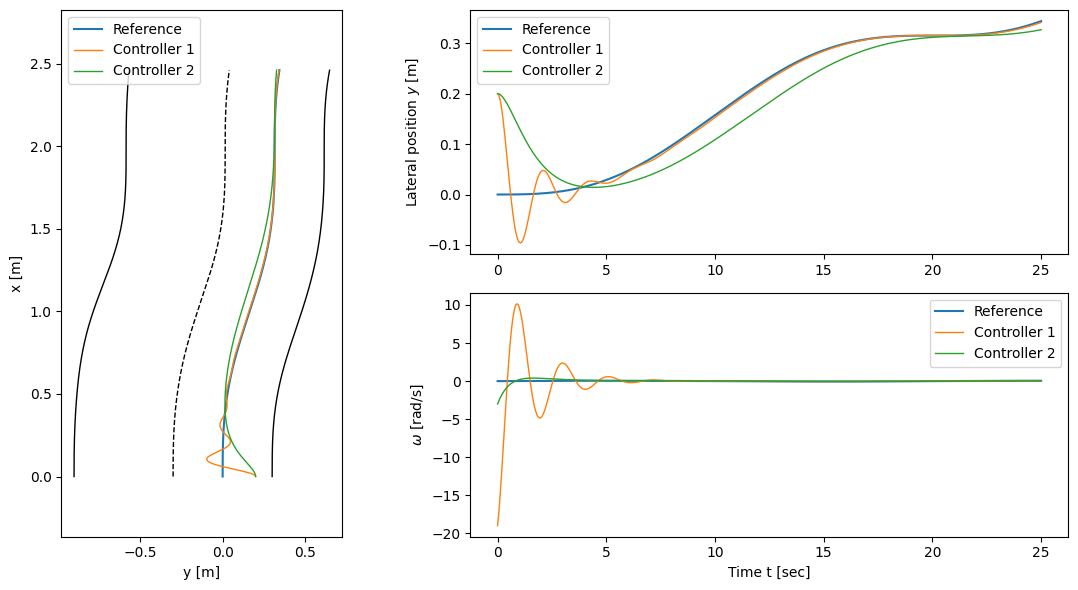

In [62]:
# Define reference values & initial conditions
x_ref = x_curvy[0]
y_ref = x_curvy[1]
theta_ref = x_curvy[2]
omega_ref = w_curvy
t = T_curvy

# Place poles according to problem description and generate 2 LTI systems
p_fast = np.array([-0.7 + 3j, -0.7 - 3j])
p_slow = np.array([-1.5, -1])
K_fast = ct.acker(A, B, p_fast)
K_slow = ct.acker(A, B, p_slow)

A_cl_fast = A - B @ K_fast
k_r_fast = -1/(C @ np.linalg.inv(A_cl_fast) @ B)
B_cl_fast = B * k_r_fast

A_cl_slow = A - B @ K_slow
k_r_slow = -1/(C @ np.linalg.inv(A_cl_slow) @ B)
B_cl_slow = B * k_r_slow

sys_fast = ct.ss(A_cl_fast, B_cl_fast, C, D)
sys_slow = ct.ss(A_cl_slow, B_cl_slow, C, D)

# Simulate the system response to the reference input

t, yf, xf = ct.forced_response(sys_fast, T_curvy, y_ref, X0 = x_0, return_x=True)
omegaf = - K_fast @ xf + k_r_fast * y_ref
t, ys, xs = ct.forced_response(sys_slow, T_curvy, y_ref, X0=x_0, return_x=True)
omegas = -K_slow @ xs + k_r_slow * y_ref

# Plot the results
y = np.array([yf, ys])
omega = np.array([omegaf[0], omegas[0]])

plot_track_multiple_controller(x_ref, y_ref, theta_ref, t, omega_ref, y, omega)

As you can see, the aggressive controller captures the reference much quicker and stays closer to it afterwards. The oscillations could even be reduced by placing the poles closer to the real axis. Why don't we just place our poles at $-\infty$? The answer can be found looking at the plot for $\omega$. You can see that the aggressive controller, starting from the same initial condition, commands a control action about 6 times higher in magnitude than the slower controller. Even if the physical system can follow this input, it is energetically much more expensive than the slow controller solution. More often, the control actuators on a real system can only follow an input up to a certain magnitude until saturating, resulting in much degraded system performance compared to the simulation that isn't affected by input saturation.

Thus, there is some sort of tradeoff between reference tracking and expended input energy. One way to design a controller that takes this into account when choosing control action is to quantify the tradeoff in a cost function. The resulting control problem is solved by the $\textbf{Linear Quadratic Regulator}.$


# Cost Function and the Linear Quadratic Regulator


In order to solve this problem, we define a cost function $J$:  
$$J = \int_0^{\infty}u^TRu + x^TQx + 2x^TNu \;dt$$  
where $u$ is the input of the system, $x$ are the states of the system and $R, Q, N$ are the weighting matrices. Our goal is to minimize the cost function $J$. We choose the entries of the weighting matrices according to what we want to punish more.  
Most of the times we assume the interactive matrix $N$ to be zero. The Matrices $R$ and $Q$ need to be symmetric and positive definite. Notice that the first two terms are quadratic forms in $u$ and $x$ respectively. Intuitively, you can think of $J$ as the square of the norm of $u$ and $x$, summed up over all $t$. The weighting matrices allow us to weigh certain states and, in the MIMO case, inputs differently from others. Provided some conditions on controllability and observability are fulfilled, there exists a stabilizing controller that minimizes the given cost function for any initial condition. This controller always takes the form $u = -K_{LQR}x$, i.e. it is a state feedback controller with constant gain. This is somewhat surprising, as we made no assumptions on the controller structure beforehand. Also note that this is framed as a regulator problem, i.e. the control objective is to drive the state to the origin from some nonzero initial condition. This might seem restrictive, but a reference tracking problem can be rephrased in this way without too much effort.

### Exercise X.1 
Write a function that checks whether the some R and Q are symmetric and positive definite. You can check if your function works with the given matrices.

In [270]:
#The given matrices for testing
A1 = np.array([[6, -2, -3], [-2, 7, 5] , [-3, 5, 6]]) #symmetric and positive definite
A2 = np.array([[1, -2, -3], [-2, 7, 5] , [-3, 5, 1]]) #symmetric and not positive definite
A3 = np.array([[3.25, -7.5, -12], [3.375, 17.75, 22] , [-2.0625, -7.125, -8]]) #not symmetric and positive definite
A4 = np.array([[1, 3, 5], [2, 2, 5] , [-3, 7, 1]]) #not symmetric and not positive definite
A_test = A1

# TODO: Check if the matrix is symmetric and positive definite

def check_pos_def_sym(A: np.array) -> bool:
    return np.all(np.linalg.eigvals(A) > 0) and np.all(A == A.T)
print(check_pos_def_sym(A_test))

True


Now that we can check that our matrices have the necessary properties, we can try to find the input $u(t) = -K_{LQR}x(t)$ that minimizes the cost function. The optimal solution is given by the Algebraic Ricatti Equation:  
$$A^TP + PA - (N + PB)R^{-1}(N^T + B^TP) + Q = 0$$
Once we have found $P$ we can determine the optimal state feedback gain matrix with the formula:   
$$K_{LQR} = R^{-1}(N + PB)^T$$


### Exercise X.2
Write a function that calculate P through the Algeabraic Riccati Equation and determine the state feedback gain matrix $K_{LQR}$. The function should also check if $Q$ and $R$ are symmetric and positive definite using your solution from Exercise X.1
You may use the function ct.care(A, B, Q, R)[0] to calculate P.

In [271]:
# Define the weighting matrices Q and R
Q = np.array([[7, 8], [8, 10]])
R = np.array([[11]])

def K_LQR(A: np.array, B: np.array, Q: np.array, R: np.array) -> np.array:
# TODO check if the chosen Q and R are symmetric and positive definite
    valid = check_pos_def_sym(Q) & check_pos_def_sym(R)
# TODO: Calculate P using the care function and evaluate the state feedback gain matrix K_LQR
    if valid:
        P = ct.care(A, B, Q, R)[0]
        K_LQR = np.linalg.inv(R) @ np.transpose(P @ B)
        return(K_LQR)
    else:
        return("The chosen Q and R are not symmetric and/or positive definite")

print(K_LQR(A, B, Q, R))


[[0.79772404 1.03374838]]


The next section visualizes the Step Response of the LQR controller for different weighting matrices. 

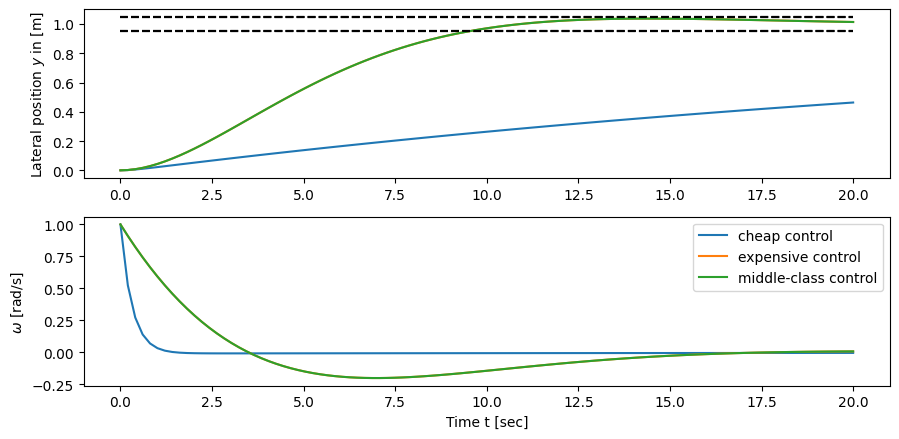

In [334]:
#cheap control
Q1 = np.array([[10, 0], [0, 100]])
R1 = np.array([[10]])
#expensive control
Q2 = np.array([[10, 0], [0, 0.1]])
R2 = np.array([[10]])
#middle-class control
Q3 = np.array([[10, 0], [0, 0.1]])
R3 = np.array([[10]])



K_LQR_1 = K_LQR(A, B, Q1, R1)
A_cl_1 = A - B @ K_LQR_1
K_LQR_2 = K_LQR(A, B, Q2, R2)
A_cl_2 = A - B @ K_LQR_2
K_LQR_3 = K_LQR(A, B, Q3, R3)
A_cl_3 = A - B @ K_LQR_3

k_r_1 = -1/(C @ np.linalg.inv(A_cl_1) @ B)
k_r_2 = -1/(C @ np.linalg.inv(A_cl_2) @ B)
k_r_3 = -1/(C @ np.linalg.inv(A_cl_3) @ B)
B_cl_1 = B * k_r_1
B_cl_2 = B * k_r_2
B_cl_3 = B * k_r_3

syscl_1 = ct.ss(A_cl_1, B_cl_1, C, D)
syscl_2 = ct.ss(A_cl_2, B_cl_2, C, D)
syscl_3 = ct.ss(A_cl_3, B_cl_3, C, D)

# Compute the step response
t_1, y_1, x_1 = ct.step_response(syscl_1, T=np.linspace(0, 20, 100), return_x=True)
t_2, y_2, x_2= ct.step_response(syscl_2, T=np.linspace(0, 20, 100), return_x=True)
t_3, y_3, x_3= ct.step_response(syscl_3, T=np.linspace(0, 20, 100), return_x=True)
# Compute the input used to generate the control response (check lecture slides)
u_1 = -K_LQR_1 @ x_1 + k_r_1 * 1
u_2 = -K_LQR_2 @ x_2 + k_r_2 * 1
u_3 = -K_LQR_3 @ x_3 + k_r_3 * 1
# Configure matplotlib plots to be a bit bigger and optimize layout
plt.figure(figsize=[9, 4.5])
# Plot the results
plot_step_response(t_1, y_1, u_1)
plot_step_response(t_2, y_2, u_2)
plot_step_response(t_3, y_3, u_3)
plt.legend(['cheap control', 'expensive control', 'middle-class control'])
plt.tight_layout()

plt.show()

